In [73]:
!python -m pip install --upgrade pip
!pip install pydicom

Requirement already up-to-date: pip in /home/rico-li/anaconda3/lib/python3.7/site-packages (20.2.1)
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [1]:
import os
import sys
sys.path.append('/home/rico-li/.local/lib/python2.7/site-packages')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import pydicom
from pydicom import dcmread
import imageio

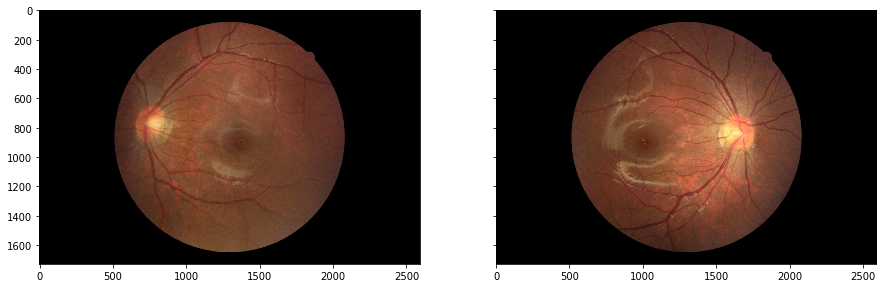

In [5]:
dcm_path_1 = '000/08CCC41E796BCBBB4662366677D712CE8B911000/2F48466EF0B512237DF48714F7A2DF291DE59E08/2f6c7abf9519f65157f2df9b0138df36.dcm'
dcm_path_2 = '000/08CCC41E796BCBBB4662366677D712CE8B911000/2F48466EF0B512237DF48714F7A2DF291DE59E08/56a4d274c7033039a0f5844a39f8c057.dcm'
ds1 = dcmread(dcm_path_1)
ds2 = dcmread(dcm_path_2)

img1 = ds1.pixel_array
img2 = ds2.pixel_array

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)

ax1.imshow(img1)
ax2.imshow(img2)

plt.show()



In [14]:
ds = dcmread(dcm_path_1)
print(ds)

(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.392.200046.100.3.8.102940.2109.20181121144534.1.1.1.2
(0008, 0020) Study Date                          DA: '20181121'
(0008, 0021) Series Date                         DA: '20181121'
(0008, 0023) Content Date                        DA: '20181121'
(0008, 0030) Study Time                          TM: '144436'
(0008, 0031) Series Time                         TM: '144533'
(0008, 0033) Content Time                        TM: '144533'
(0008, 0050) Accession Number                    SH: '93KJ6909jjj10'
(0008, 0060) Modality                            CS: 'OT'
(0008, 0061) Modalities in Study                 CS: 'OT'
(0008, 0064) Conversion Type                     CS: 'DI'
(0008, 0070) Manufacturer               

* (0008, 0005): The element’s tag, as **(group number, element number)** in hexadecimal
* Specific Character Set: the element’s name, if known
* CS: The element’s **[Value Representation](http://dicom.nema.org/medical/dicom/current/output/chtml/part05/sect_6.2.html) (VR)** (check the link for detail table), if known
* ‘ISO_IR_100’: the element’s stored value

# Elements
* **Standard elements** such as (0008,0016) SOP Class UID. These elements are registered in the official DICOM Standard, have an even group number and are unique at each level of the dataset.
* **Repeating group elements** such as (0008, 1032) Overlay Data. Repeating group elements are also registered in the official DICOM Standard, however they have a group number defined over a range rather than a fixed value. For example, there may be multiple Overlay Data elements at a given level of the dataset as long as each has its own unique group number; 0x6000, 0x6002, 0x6004, or any even value up to 0x601E.
* **Private elements** such as (0903, 0010) [Reject Image Flag]. Private elements have an odd group number, aren’t registered in the official DICOM Standard, and are instead created privately, as specified by the (0903, 0010) Private Creator element.
    * If the private creator is unknown then the element name will be Private tag data and the VR UN.
    * If the private creator is known then the element name will be surrounded by square brackets, e.g. [Reject Image Flag] and the VR will be as shown.

In [29]:
# accessing one of the elements
# use the '0x' before the tags
elem = ds[0x020, 0x020]
print('Standard elements\n')
print(elem)
print(elem.keyword)
print(elem.value)
# using keyword
print(ds['PatientOrientation'])

print('\n-----\n')

print('Pirvate elements\n')
private_elem = ds[0x3109, 0x1008]
print(private_elem)
print(private_elem.keyword) # no display
print(private_elem.value)

Standard elements

(0020, 0020) Patient Orientation                 CS: ['L', 'F']
PatientOrientation
['L', 'F']
(0020, 0020) Patient Orientation                 CS: ['L', 'F']

-----

Pirvate elements

(3109, 1008) [Receive Origin]                    LO: 'lqn5.cgmf.org.tw'

lqn5.cgmf.org.tw


## Sequences
In some elements, they have the following structure:
```
(0008, 1032)  Procedure Code Sequence   1 item(s) ---- 
   (0008, 0100) Code Value                          SH: '316102'
   (0008, 0102) Coding Scheme Designator            SH: 'GEIIS'
   (0008, 0103) Coding Scheme Version               SH: '0'
   (0008, 0104) Code Meaning                        LO: 'META Retinal'
```

The main difference between sequence and non-sequence elements is that their value is a list of zero or more Dataset objects, which can be accessed using the standard Python list methods:


In [31]:
seq = ds[0x0008, 0x1032]
# print(len(seq)) # in our case, only 1 item exist. Therefore seq is the DataElement
print(seq)

(0008, 1032) Procedure Code Sequence             SQ: <Sequence, length 1>


# Image
If one only concerns with image, then only the element `Pixel Data` has to be considered.

In [33]:
dcm_path_1 = '0A0/176441EB07C8BC10506A8CB22A9E18E4BC73F0A0/6899F173E20D517908CAAFD87F87900D9B1B00B9/42d89ea1ec33a7d20e31f4810f3fde0f.dcm'
dcm_path_2 = '0A0/176441EB07C8BC10506A8CB22A9E18E4BC73F0A0/6899F173E20D517908CAAFD87F87900D9B1B00B9/7333bcdf9765f81ff27d0080ea651867.dcm'

name_1 = dcm_path_1.split('/')[-1]
name_2 = dcm_path_2.split('/')[-1]

ds1 = dcmread(dcm_path_1)
ds2 = dcmread(dcm_path_2)

pixel_array_numpy = ds1.pixel_array
ds2 = pydicom.read_file(dcm_path_2)

img1 = ds1.pixel_array
img2 = ds2.pixel_array

# print(img1.shape)
# print(np.amin(img1[...,2]))

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
fig.suptitle('file path: 0A0/176441EB07C8BC10506A8CB22A9E18E4BC73F0A0/6899F173E20D517908CAAFD87F87900D9B1B00B9')
fig.set_figheight(5)
fig.set_figwidth(20)

ax1.imshow(img1)
ax1.set_title(f'file name: {name_1}')
ax2.imshow(img2)
ax2.set_title(f'file name: {name_2}')

plt.show()

0


In [20]:
def show_ds(ds_path):
    ds = dcmread(ds_path)
    print('\n')
    print(f'file: {ds_path}')
    print('-------')
    print(f'The number of elements in file: {len(ds.keys())}')
    print(f'PatientName: {ds.PatientName}')
    print(f'PatientID: {ds.PatientID}')
    print(f'PatientBirthDate: {ds.PatientBirthDate}')
    print(f'PatientAge: {ds.PatientAge}')
    print(f'PatientOrientation: {ds.PatientOrientation}')
    print(f'PatientSex: {ds.PatientSex}')
    print(f'Laterality: {ds.Laterality}')
    print(f'image (row, col): ({ds.Rows}, {ds.Columns})')

def ds_plot(ds_path:str):
    '''
    Note that the ds_path should only contain 2 .dcm file
    '''
    list_path = os.listdir(ds_path)
    dcm_path_1 = list_path[0]
    dcm_path_2 = list_path[1]
    ds1 = dcmread(os.path.join(ds_path, dcm_path_1))
    ds2 = dcmread(os.path.join(ds_path, dcm_path_2))

    if ds1.Laterality== 'R':
        dsR = ds1
        dsL = ds2
        dcm_path_R = dcm_path_1
        dcm_path_L = dcm_path_2
    else:
        dsR = ds2
        dsL = ds1
        dcm_path_R = dcm_path_2
        dcm_path_L = dcm_path_1

    img_R = dsR.pixel_array
    img_L = dsL.pixel_array

    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.suptitle(f'file path: {ds_path}')
    fig.set_figheight(7)
    fig.set_figwidth(20)

    ax1.imshow(img_R)
    ax1.set_title(f'file name: {dcm_path_1} \n R eye')
    ax2.imshow(img_L)
    ax2.set_title(f'file name: {dcm_path_2} \n L eye')

    plt.show()


# File Structure

In [21]:
#                                                  0A0
#                         __________________________|___________________________________________________________          
#                         |                                                     |                               |
# 176441EB07C8BC10506A8CB22A9E18E4BC73F0A0                BAA73D38B6BFA1B4026498247F8194BB05C790A0             ...
#                         |                                                     |
# 6899F173E20D517908CAAFD87F87900D9B1B00B9                                     ...
#                         |_______________________________
#                         |                               |
# 42d89ea1ec33a7d20e31f4810f3fde0f.dcm    7333bcdf9765f81ff27d0080ea651867.dcm

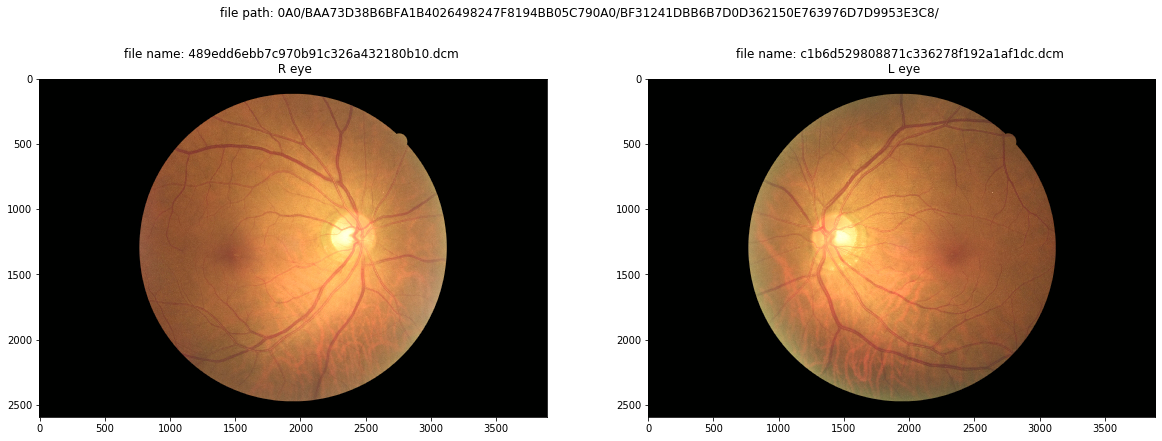



file: 0A0/BAA73D38B6BFA1B4026498247F8194BB05C790A0/BF31241DBB6B7D0D362150E763976D7D9953E3C8/489edd6ebb7c970b91c326a432180b10.dcm
-------
The number of elements in file: 74
PatientName: f3872bc9495bed6530814b4b8b126f07
PatientID: BAA73D38B6BFA1B4026498247F8194BB05C790A0
PatientBirthDate: 19571201
PatientAge: 057Y
PatientOrientation: ['L', 'F']
PatientSex: M
Laterality: R
image (row, col): (2592, 3888)


file: 0A0/BAA73D38B6BFA1B4026498247F8194BB05C790A0/BF31241DBB6B7D0D362150E763976D7D9953E3C8/c1b6d529808871c336278f192a1af1dc.dcm
-------
The number of elements in file: 74
PatientName: f3872bc9495bed6530814b4b8b126f07
PatientID: BAA73D38B6BFA1B4026498247F8194BB05C790A0
PatientBirthDate: 19571201
PatientAge: 057Y
PatientOrientation: ['L', 'F']
PatientSex: M
Laterality: L
image (row, col): (2592, 3888)


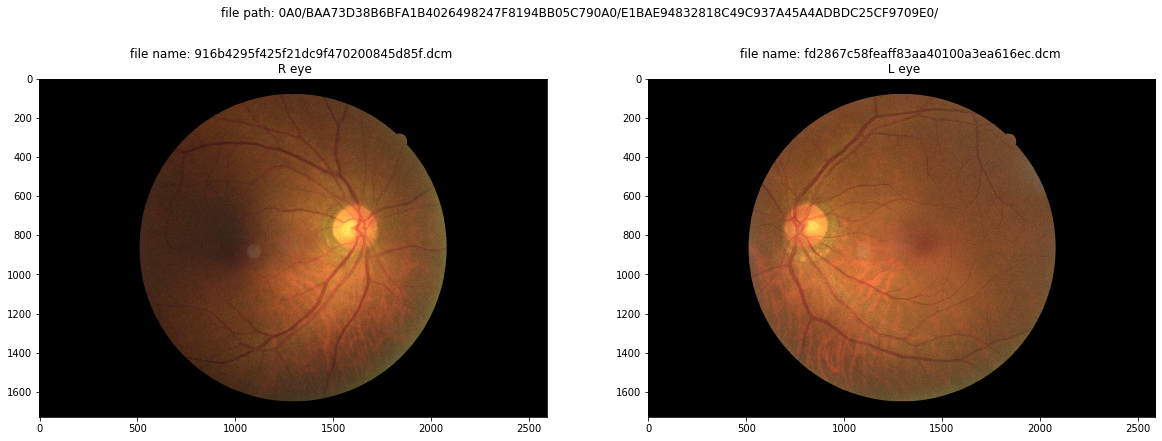



file: 0A0/BAA73D38B6BFA1B4026498247F8194BB05C790A0/E1BAE94832818C49C937A45A4ADBDC25CF9709E0/916b4295f425f21dc9f470200845d85f.dcm
-------
The number of elements in file: 75
PatientName: 005ccd6d5e4435bd9a2783a2d21d88ed
PatientID: BAA73D38B6BFA1B4026498247F8194BB05C790A0
PatientBirthDate: 19571201
PatientAge: 060Y
PatientOrientation: ['L', 'F']
PatientSex: M
Laterality: R
image (row, col): (1728, 2592)


file: 0A0/BAA73D38B6BFA1B4026498247F8194BB05C790A0/E1BAE94832818C49C937A45A4ADBDC25CF9709E0/fd2867c58feaff83aa40100a3ea616ec.dcm
-------
The number of elements in file: 75
PatientName: 005ccd6d5e4435bd9a2783a2d21d88ed
PatientID: BAA73D38B6BFA1B4026498247F8194BB05C790A0
PatientBirthDate: 19571201
PatientAge: 060Y
PatientOrientation: ['L', 'F']
PatientSex: M
Laterality: L
image (row, col): (1728, 2592)


In [22]:
# under OAO
# has 176441EB07C8BC10506A8CB22A9E18E4BC73F0A0
# and BAA73D38B6BFA1B4026498247F8194BB05C790A0

# BAA73D38B6BFA1B4026498247F8194BB05C790A0 contains
# BF31241DBB6B7D0D362150E763976D7D9953E3C8 and E1BAE94832818C49C937A45A4ADBDC25CF9709E0

# in BF31241DBB6B7D0D362150E763976D7D9953E3C8
ds_plot('0A0/BAA73D38B6BFA1B4026498247F8194BB05C790A0/BF31241DBB6B7D0D362150E763976D7D9953E3C8/')
show_ds('0A0/BAA73D38B6BFA1B4026498247F8194BB05C790A0/BF31241DBB6B7D0D362150E763976D7D9953E3C8/489edd6ebb7c970b91c326a432180b10.dcm')
show_ds('0A0/BAA73D38B6BFA1B4026498247F8194BB05C790A0/BF31241DBB6B7D0D362150E763976D7D9953E3C8/c1b6d529808871c336278f192a1af1dc.dcm')

# in E1BAE94832818C49C937A45A4ADBDC25CF9709E0
ds_plot('0A0/BAA73D38B6BFA1B4026498247F8194BB05C790A0/E1BAE94832818C49C937A45A4ADBDC25CF9709E0/')
show_ds('0A0/BAA73D38B6BFA1B4026498247F8194BB05C790A0/E1BAE94832818C49C937A45A4ADBDC25CF9709E0/916b4295f425f21dc9f470200845d85f.dcm')
show_ds('0A0/BAA73D38B6BFA1B4026498247F8194BB05C790A0/E1BAE94832818C49C937A45A4ADBDC25CF9709E0/fd2867c58feaff83aa40100a3ea616ec.dcm')

In [183]:
def dir_list(path, parent_bol:bool=False):
    if parent_bol:
        parents_list = os.listdir(path)
        parents_list = [os.path.join(path,parent) for parent in parents_list if len(parent) == 3]    
        return parents_list
    else:
        try:
            sons_list = os.listdir(path)
            sons_list = [os.path.join(path, son) for son in sons_list]
            return sons_list
        except:
            return [path]
            

def dir_com(parent_list):
    son_list = []
    for p in parent_list:
        s_list = dir_list(p)
        son_list += s_list
    return son_list

def ds_save(ds_path_list:list, csv_save_path:str, img_save_path:str):
    # the location of img saved
    if not os.path.exists(img_save_path):
        os.mkdir(img_save_path)
    path = []
    name = []
    ID = []
    age = []
    sex = []
    lat = []
    row = []
    col = []
    for i, ds_path in enumerate(ds_path_list):
        ds = dcmread(ds_path)
        ds_path = ds_path.replace('/home/rico-li/Job/Ophthalmoscope/','')
        path += [ds_path]
        name += [ds.PatientName]
        ID += [ds.PatientID]
        age += [ds.PatientAge]
        sex += [ds.PatientSex]
        lat += [ds.PatientSex]
        row += [ds.Rows]
        col += [ds.Columns]

        img = ds.pixel_array
        img_name = ds_path.split('/')[-1]
        img_name = img_name.split('.dcm')[0]+'.jpg'

        # imageio.imwrite(os.path.join(img_save_path, img_name), img) #<- slower
        # im = Image.fromarray(img)
        # im.save(os.path.join(img_save_path, img_name)) #<- slower
        cv2.imwrite(os.path.join(img_save_path, img_name), img) # faster
        
        if (i+1) % 10 == 0:
            print(f'Save img log: {i+1} images saved')

    df = pd.DataFrame({
                       'path': path,
                       'name': name,
                       'ID':ID,
                       'age':age,
                       'sex':sex,
                       'lat':lat,
                       'row':row,
                       'col':col
                       })
    df.to_csv(os.path.join(csv_save_path, 'ophthalmoscope.csv'), index = False)
    print(f'Total {len(ID)} dcm are processed')

def image_cp(mode, names, df):
    assert mode in ['train','val', 'test']
    if not os.path.exists('train'):
        os.mkdir('train')
    if not os.path.exists('val'):
        os.mkdir('val')
    if not os.path.exists('test'):
        os.mkdir('test')
    for name in names:
        file_names = df[df['name'] == name]['path'].values
        file_names = [file_name.split('/')[-1][:-4]+'.jpg'  for file_name in file_names]
        images_path = [os.path.join('images', file_name) for file_name in file_names]
        
        cp_act = [copyfile(image_path, os.path.join(f'{mode}', image_path.split('/')[-1]) ) for image_path in images_path]
    print('cp done')
    print(f'mode: {mode}')
    print(f'total images: {len(names)}')


In [131]:
p_list = dir_list(os.getcwd(),True)
s1_list = dir_com(p_list)
s2_list = dir_com(s1_list)
s3_list = dir_com(s2_list)
check_list = ['Not complete path' for i in s3_list if not i.endswith('.dcm')]

if check_list:
    print(check_list[0])
else:
    print('All path complete!')

All path complete!


In [143]:
import time
start_time = time.time()
ds_save(s3_list, os.getcwd(), os.path.join(os.getcwd(),'images'))
print(f'Execute time: %.2f' % (time.time() - start_time))

Save img log: 10 images saved
Save img log: 20 images saved
Save img log: 30 images saved
Total 34 dcm are processed
Execute time: 4.65


In [188]:
from shutil import copyfile
split_index = [0.6, 0.7] # train, val, test (0.6, 0.1, 0.3)

images = os.listdir('images')
images_path = [os.path.join('images', image) for image in images]
df = pd.read_csv('ophthalmoscope.csv')
# df
names = df['name']
names = names.unique()
np.random.seed(42)
np.random.shuffle(names)

print(int(len(names)*split_index[1]))

train_names = names[:int(len(names)*split_index[0])]
val_names = names[int(len(names)*split_index[0]) : int(len(names)*split_index[1])]
test_names = names[int(len(names)*split_index[1]):]

image_cp('train',train_names,df)
image_cp('val',val_names,df)
image_cp('test',test_names,df)

10
cp done
mode: train
total images: 9
cp done
mode: val
total images: 1
cp done
mode: test
total images: 5


In [164]:
copyfile('images/0d10c40e6860a901cf3c7c9e90c5b67d.jpg', 'train/0d10c40e6860a901cf3c7c9e90c5b67d.jpg')

'train/0d10c40e6860a901cf3c7c9e90c5b67d.jpg'

In [8]:
import multiprocessing as mp
import cv2
import os
import time 

def imread(path):
    img = cv2.imread(path)

path = '/home/rico-li/Job/Ophthalmoscope/images'
names = os.listdir(path)
img_paths = [os.path.join(path,name) for name in names]

In [9]:
start_time = time.time()

for img_path in img_paths:
    imread(img_path)

print(f'spending time: % .2f sec' % (time.time()-start_time))


spending time:  1.97 sec


In [12]:
start_time = time.time()

processes = []
for img_path in img_paths:
    p = mp.Process(target=imread, args=[img_path])
    p.start()
    processes.append(p)

for process in processes:
    process.join()

print(f'spending time: % .2f sec' % (time.time()-start_time))


spending time:  0.41 sec


In [1]:
import pandas as pd

df = pd.read_csv('ophthalmoscope_v3.csv')

In [11]:
df_age = df[df['quality'] == 0]['age']
df_age = df_age.dropna()

[ 1716  2371 14091 20617  2827]


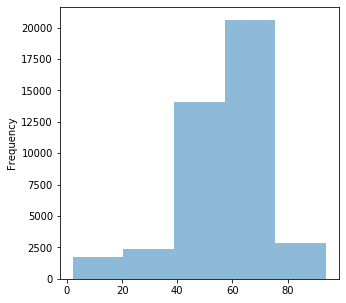

In [19]:
n = df_age.plot.hist(bins=5, alpha=0.5,figsize = (5,5))
count, division = pd.np.histogram(df_age,bins=5)
print(count)

In [2]:
df['quality'].value_counts()

0.0    41622
2.0    13933
1.0     8531
Name: quality, dtype: int64

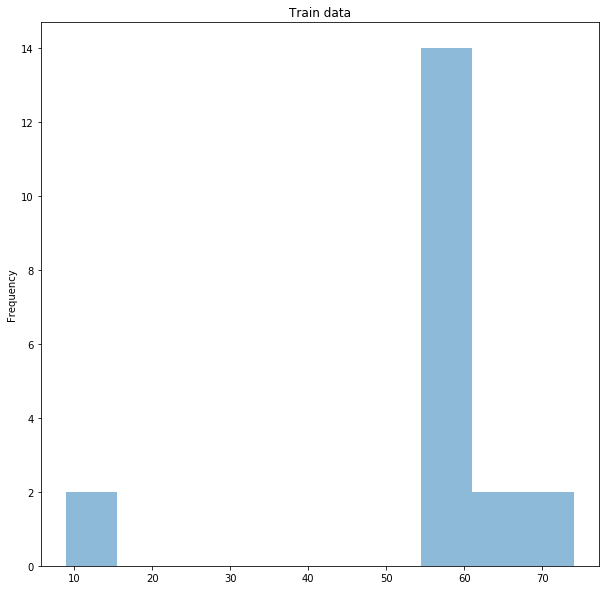

In [15]:
import pandas as pd
import os
df = pd.read_csv('ophthalmoscope_v3.csv')

mode = 'train'
quality = 'good'

paths = mode
paths = os.path.join(paths,'clahe')
paths = [os.path.join(paths, class_name) for class_name in os.listdir(paths)]
paths = [os.path.join(path, quality) for path in paths]
image_paths = [os.path.join(path, file_name) for path in paths for file_name in os.listdir(path)] 

names = [image_path.split('/')[-1][:-4] for image_path in image_paths]

mode_age = df[df['path'].isin(names)]['age']
mode_age.plot.hist(bins=10, alpha=0.5,figsize = (10,10), title='Train data')